In [25]:
from numpy.random import randint
from numpy.random import rand
from collections import namedtuple
from random import *
from datetime import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt

# identifying the structure of Item (Object) and Candidate (A possible solution) 
Item = namedtuple("Item", ['id', 'size'])
Candidate = namedtuple("Candidate", ['items', 'fitness'])

In [26]:
# The function cost returns the cost of a collection of bins that is represented by these bins length
def cost(bins):
    return len(bins)
#________________________________________The class Bin________________________________________________________
class Bin(object):
    count = itertools.count()
    
    #This procedure simply create a new bin
    #The items contained on a bin are defined by their index in its items table 
    def __init__(self, capacity):
        self.id = next(Bin.count)
        self.capacity = capacity
        self.free_space = capacity
        self.items = []
        self.used_space = 0
    
    #This procedure adds a new item to a specific bin and update the values of used and free spaces
    def add_item(self, item):
        self.items.append(item)
        self.free_space -= item.size
        self.used_space += item.size
    
    #This procedure removes a specific item in a specific bin and update the values of used and free spaces
    def remove_item(self, item_index):
        item_to_remove = self.items[item_index]
        del self.items[item_index]
        self.free_space += item_to_remove.size
        self.used_space -= item_to_remove.size

    
    #This function allows us to know if we can add a specific item to a  specific bin or not
    def fits(self, item):
        return self.free_space >= item.size

    
    #This function display the content of a specific bin 
    def __str__(self):
        items = [str(it) for it in self.items]
        items_string = '[' + ' '.join(items) + ']'
        return "Bin n° " + str(self.id) + " containing the " + \
               str(len(self.items)) + " following items : " + items_string + \
               " with " + str(self.free_space) + " free space."
    
    #This function copy a bin into a new one with keeping the old bin
    def __copy__(self):
        new_bin = Bin(self.capacity)
        new_bin.free_space = self.free_space
        new_bin.used_space = self.used_space
        new_bin.items = self.items[:]
        return new_bin
        

In [27]:
#Now we will be introducing the different procedures and functions
#that allows us to build our Genetic Algorithm : 
# ----> Different Heuritic methods to help us define the fitness function
# ----> Population generator
# ----> Parents selection algorithms
# ----> Crossover algorithm
# ----> Mutation algorithm
#___________________________________________Heuristics_________________________________________________

def firstfit(items, current_bins, capacity):
    bins = [copy.copy(b) for b in current_bins]
    if not bins:
        bins = [Bin(capacity)]
    for item in items:
        if item.size > capacity:
            continue
        first_bin = next((bin for bin in bins if bin.free_space >= item.size), None)
        if first_bin is None:
            bin = Bin(capacity)
            bin.add_item(item)
            bins.append(bin)
        else:
            first_bin.add_item(item)
    return bins

In [28]:
#_______________________________Population Generator____________________________
# This function generates the initial population randomly 
def population_generator(items, capacity, population_size, greedy_solver):
    candidate = Candidate(items[:], fitness(items, capacity, greedy_solver))
    population = [candidate]
    #print(len(population[0].fitness))
    new_items = items[:]
    for i in range(population_size - 1):
        shuffle(new_items)
        candidate = Candidate(new_items[:], fitness(new_items, capacity, greedy_solver))
        if candidate not in population:
            population.append(candidate)
    return population


In [29]:
#____________________________________fitness___________________________
def fitness(candidate, capacity, greedy_solver):
    if greedy_solver == 'FF':
        return firstfit(candidate,[], capacity)

In [30]:
#________________________________Selection Methods__________________
# In K-Way tournament selection, we select K individuals from the population 
# at random (using a geometric function) 
# and select the best out of these to become a parent with a trournament_selection probability. 
# The same process is repeated for selecting the next parent.
def tournament_selection(population, tournament_selection_probability, k):
    candidates = [population[(randint(0, len(population) - 1))]]
    while len(candidates) < k:
        new_indiv = population[(randint(0, len(population) - 1))]
        if new_indiv not in candidates:
            candidates.append(new_indiv)
    ind = int(np.random.geometric(tournament_selection_probability, 1))
    while ind >= k:
        ind = int(np.random.geometric(tournament_selection_probability, 1))
    return candidates[ind]

In [31]:
def roulette_wheel_selection(population):
    max = sum([len(e.fitness) for e in population])
    pick = uniform(0, max)
    current = max
    for item in population:
        current -= len(item.fitness)
        if current < pick:
            return item

In [32]:
def SUS(population, n):
    selected = []
    pointers = []
    max = sum([len(e.fitness) for e in population])
    distance = max / n
    start = uniform(0, distance)
    for i in range(n):
        pointers.append(start + i * distance)
    for pointer in pointers:
        current = 0
        for item in population:
            current += len(item.fitness)
            if current > pointer:
                selected.append(item)
    return selected

In [33]:
def rank_selection(population):
    length = len(population)
    rank_sum = length * (length + 1) / 2
    pick = uniform(0, rank_sum)
    current = 0
    i = length
    for item in population:
        current += i
        if current > pick:
            return item
        i -= 1

In [34]:
#______________________________Crossover____________________________
def crossover(parent1, parent2):
    taken = [False] * len(parent1)
    child = []
    i = 0
    while i < len(parent1):
        element = parent1[i]
        if not taken[element.id]:
            child.append(element)
            taken[element.id] = True
        element = parent2[i]
        if not taken[element.id]:
            child.append(element)
            taken[element.id] = True
        i += 1
    return child 

In [35]:
#______________________________________Mutation_____________________
def mutation(member, capacity, greedy_solver):
    member_items = member.items
    a = randint(0, len(member_items) - 1)
    b = randint(0, len(member_items) - 1)
    while a == b:
        b = randint(0, len(member_items) - 1)
    c = member_items[a]
    member_items[a] = member_items[b]
    member_items[b] = c
    member = Candidate(member_items, fitness(member_items, capacity, greedy_solver))
    return member

In [36]:
def readFromFile(file):
    fichier = open(file, "r")
    w=[]
    i=0
    for line in fichier:
        if i==0:
            n=int(line)
            i=i+1  
        else:
            if i==1:
                c=int(line)
                i=i+1
            else: 
                if i>1:
                    w.append(int(line.rstrip('\n\r')))
                    i=i+1
    fichier.close()
    return n,c,w

In [60]:
#______________________________________Genetic Algorithm________________
def genetic_algorithm(weights, capacity, population_size, generations, max_no_change,k, tournament_selection_probability, crossover_probability, mutation_probability, greedy_solver, allow_duplicate_parents, selection_method):

    items = [Item]
    items = [ Item(i,weights[i]) for i in range(len(weights))]
    population = population_generator(items, capacity, population_size, greedy_solver)
    best_solution = fitness(items, capacity, greedy_solver)
    i = 0
    current_iteration = 0
    num_no_change = 0
    while current_iteration < generations and num_no_change < max_no_change:
        new_generation = []
        best_child = best_solution
        for j in range(population_size):


            if selection_method == 'SUS':
                first_parent = SUS(population, 1)[0].items
                second_parent = SUS(population, 1)[0].items
                if not allow_duplicate_parents:
                    while first_parent == second_parent:
                        second_parent = SUS(population, 1)[0].items
            elif selection_method == 'TS':
                first_parent = tournament_selection(population, tournament_selection_probability, k).items
                second_parent = tournament_selection(population, tournament_selection_probability, k).items
                if not allow_duplicate_parents:
                    while first_parent == second_parent:
                        second_parent = tournament_selection(population, tournament_selection_probability, k).items
            elif selection_method == 'RW':
                first_parent = roulette_wheel_selection(population).items
                second_parent = roulette_wheel_selection(population).items
                if not allow_duplicate_parents:
                    while first_parent == second_parent:
                        second_parent = roulette_wheel_selection(population).items
            elif selection_method == 'RS':
                first_parent = rank_selection(population).items
                second_parent = rank_selection(population).items
                if not allow_duplicate_parents:
                    while first_parent == second_parent:
                        second_parent = rank_selection(population).items
            else:
                return

            child = crossover(first_parent, second_parent)
            child = Candidate(child[:], fitness(child, capacity, greedy_solver))

            prob = random()
            if prob <= mutation_probability:
                child = mutation(child, capacity, greedy_solver)

            if len(child.fitness) < len(best_child):
                best_child = child.fitness
            new_generation.append(child)

        num_no_change += 1
        if len(best_child) < len(best_solution):
            best_solution = best_child
            num_no_change = 0
        population = [Candidate(p.items[:], p.fitness) for p in new_generation]
        population.sort(key=lambda candidate: len(candidate.fitness), reverse=True)
        #if i==30:
         #   print([len(population[l].fitness) for l in range(len(population))])
        current_iteration += 1
    #for d in range(len(best_solution)):
     #   print(best_solution[d].__str__())
    print("iterations number ",current_iteration,"stagnation: ", num_no_change)
    return len(best_solution)


#weights = [49, 41, 34, 33, 29, 26, 26, 22, 20, 19, 40, 21, 45, 15, 18, 23, 43, 30,34,67,12]
#capacity = 100

POPULATION_SIZE = 50
MAX_GENERATIONS = 250
MAX_NO_CHANGE = 50
TOURNAMENT_SIZE = 20 #2
TOURNAMENT_SELECTION_RATE = 0.7
MUTATION_RATE = 0.3 #0.4
CROSSOVER_RATE = 0.6 #0.3
selection_methodes=['TS','SUS','RW','RS']
files=[r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_1\N1C1W1_R.txt',
       r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_1\N2C1W2_Q.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_1\N1C2W1_R.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_1\N1C2W4_N.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_1\N1C3W1_J.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_1\N3C1W1_T.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_1\N4C1W2_H.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_2\N1W1B1R0.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_2\N1W4B3R9.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_2\N2W1B2R9.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_2\N2W4B3R0.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_2\N3W2B3R0.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_2\N4W1B1R9.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_2\N4W4B3R9.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_3\HARD0.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_3\HARD2.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_3\HARD4.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_3\HARD6.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_3\HARD7.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_3\HARD8.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Scholl\Scholl_3\HARD9.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Randomly_Generated\BPP_1000_1000_0.2_0.8_8.txt',
      r'D:\esi\2SQ3\S2\OPT\projet\Randomly_Generated\BPP_1000_1000_0.2_0.8_9.txt']
#files=[r'D:\esi\2SQ3\S2\OPT\projet\Randomly_Generated\BPP_1000_1000_0.2_0.8_8.txt',
 #      r'D:\esi\2SQ3\S2\OPT\projet\Randomly_Generated\BPP_1000_1000_0.2_0.8_9.txt']
results=[]
for i in files:
    n, capacity, weights=readFromFile(i)
    start_time = datetime.now()
    solution = genetic_algorithm(weights, capacity, POPULATION_SIZE, MAX_GENERATIONS, MAX_NO_CHANGE,TOURNAMENT_SIZE, TOURNAMENT_SELECTION_RATE, CROSSOVER_RATE, MUTATION_RATE, 'FF',False, 'RW')
    execution_time = datetime.now() - start_time
    #print('number of objects: ',n)
    #print(solution)
    #print("execution_time: ",execution_time)
    results.append((solution,str(execution_time)))
    print(results[len(results)-1])
print (results)


iterations number  50 stagnation:  50
(25, '0:00:00.729048')
iterations number  50 stagnation:  50
(65, '0:00:02.375177')
iterations number  50 stagnation:  50
(23, '0:00:00.683172')
iterations number  50 stagnation:  50
(32, '0:00:00.820984')
iterations number  50 stagnation:  50
(16, '0:00:00.623450')
iterations number  50 stagnation:  50
(102, '0:00:05.323524')
iterations number  50 stagnation:  50
(315, '0:00:53.615149')
iterations number  97 stagnation:  50
(18, '0:00:01.912730')
iterations number  50 stagnation:  50
(6, '0:00:00.824779')
iterations number  50 stagnation:  50
(35, '0:00:02.855789')
iterations number  50 stagnation:  50
(12, '0:00:01.824166')
iterations number  50 stagnation:  50
(43, '0:00:06.584927')
iterations number  55 stagnation:  50
(178, '0:00:38.837519')
iterations number  50 stagnation:  50
(56, '0:00:15.155423')
iterations number  50 stagnation:  50
(59, '0:00:06.445547')
iterations number  50 stagnation:  50
(60, '0:00:06.770311')
iterations number  50 

<function matplotlib.pyplot.show(close=None, block=None)>

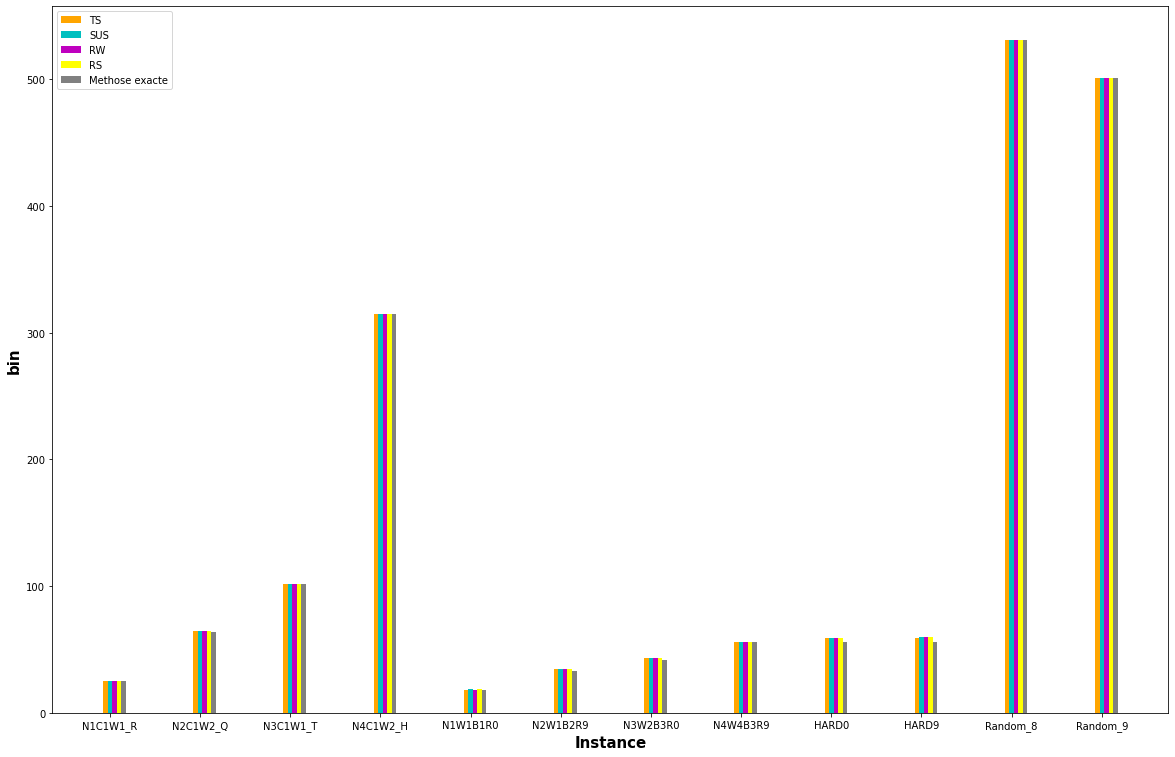

In [61]:
Instances=['N1C1W1_R','N2C1W2_Q','N3C1W1_T','N4C1W2_H','N1W1B1R0','N2W1B2R9','N3W2B3R0','N4W4B3R9','HARD0','HARD9','Random_8','Random_9']
bins_capacite_TS=[25,65,102,315,18,35,43,56,59,59,531,501]
bins_capacite_SUS=[25,65,102,315,19,35,43,56,59,60,531,501]
bins_capacite_RW=[25,65,102,315,18,35,43,56,59,60,531,501]
bins_capacite_RS=[25,65,102,315,19,35,43,56,59,60,531,501]
bins_exacte=[25,64,102,315,18,33,42,56,56,56,531,501]
barwidth = 0.05
fig = plt.subplots(figsize=(20,13))
br1=np.arange(len(Instances))
br2=[x+ barwidth for x in br1]
br3=[x+ barwidth for x in br2]
br4=[x+ barwidth for x in br3]
br5=[x+ barwidth for x in br4]
plt.bar(br1, bins_capacite_TS, color='orange', width=barwidth, label='TS')
plt.bar(br2, bins_capacite_SUS, color='c', width=barwidth, label='SUS')
plt.bar(br3, bins_capacite_RW, color='m', width=barwidth, label='RW')
plt.bar(br4, bins_capacite_RS, color='yellow', width=barwidth, label='RS')
plt.bar(br5, bins_exacte, color='grey', width=barWidth, label='Methose exacte')

plt.xlabel('Instance', fontweight='bold',fontsize=15)
plt.ylabel('bin', fontweight='bold',fontsize=15)
plt.xticks([r+barwidth for r in range (len(Instances))],Instances)
plt.legend()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

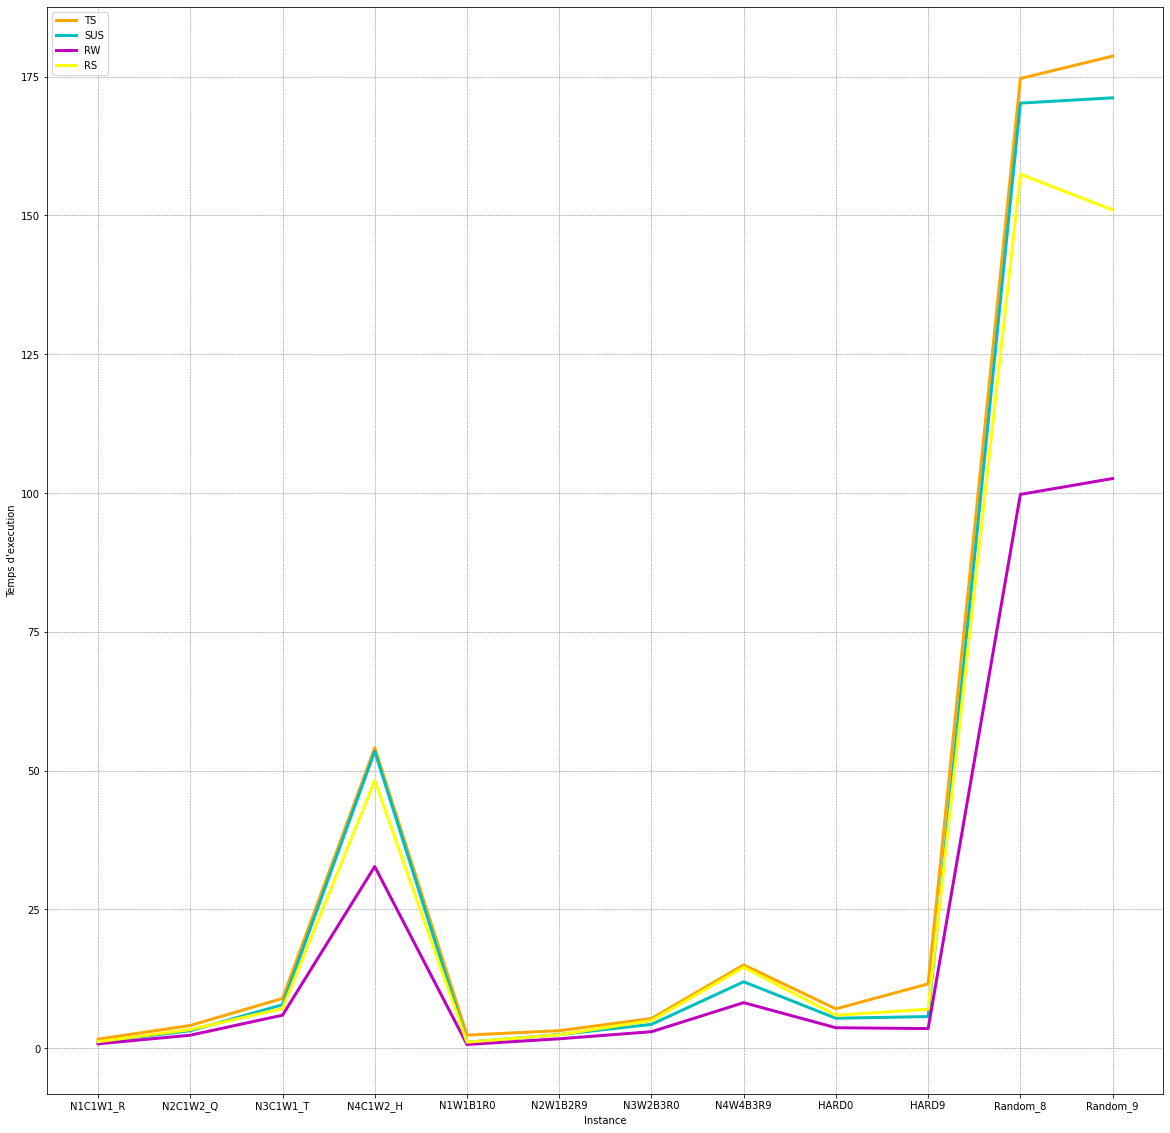

In [59]:
Instances=['N1C1W1_R','N2C1W2_Q','N3C1W1_T','N4C1W2_H','N1W1B1R0','N2W1B2R9','N3W2B3R0','N4W4B3R9','HARD0','HARD9','Random_8','Random_9']
time_TS=[01.605773,04.075372,08.951370,54.105843,02.341486,03.140669,05.329176,14.993317,07.066657,11.573571,174.684471,178.714718]
time_SUS=[01.078032,03.131946,07.810172,53.475255,01.051760,02.438821,04.269872,11.947710,05.377078,05.682232,170.246072,171.202661]
time_RW=[00.770475,02.321790,05.928852,32.710010,00.652378,01.676516,02.947876,08.189649,03.669188,03.515036,99.752432,102.610209]
time_RS=[01.154907,03.337727,07.132491,48.184516,01.065243,02.409386,04.954266,14.556725,05.913175,07.007247,157.432545,151.004432]
plt.subplots(figsize=(20,20))
br1=np.arange(len(Instances))
plt.plot(Instances, time_TS, color='orange', label='TS',linewidth=3.0)
plt.plot(Instances, time_SUS, color='c',label='SUS',linewidth=3.0)
plt.plot(Instances, time_RW, color='m',label='RW',linewidth=3.0)
plt.plot(Instances, time_RS, color='yellow', label='RS',linewidth=3.0)

plt.xlabel('Instance')
plt.ylabel("Temps d'execution")
plt.grid(color='gray', linestyle='--',linewidth=0.5)
plt.legend()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

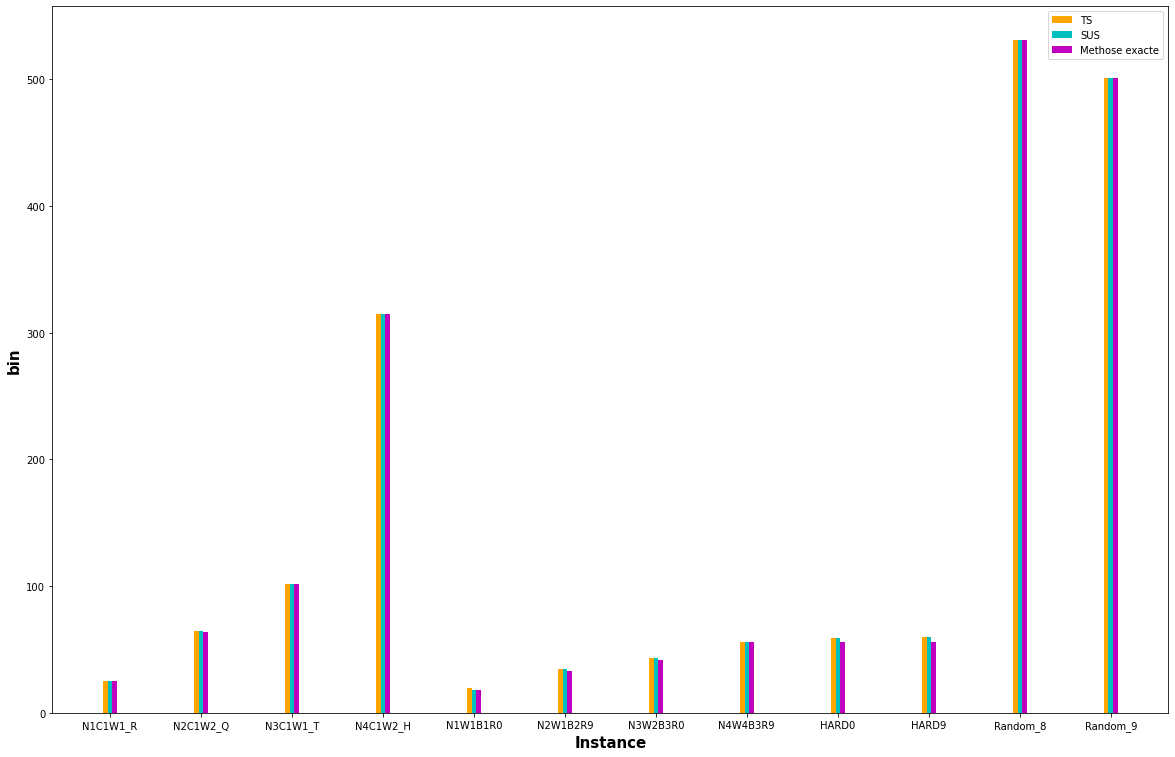

In [62]:
Instances=['N1C1W1_R','N2C1W2_Q','N3C1W1_T','N4C1W2_H','N1W1B1R0','N2W1B2R9','N3W2B3R0','N4W4B3R9','HARD0','HARD9','Random_8','Random_9']
bins_RS=[25, 65, 102, 315, 20, 35, 43, 56, 59, 60, 531, 501]
bins_AG=[25,65,102,315,18,35,43,56,59,60,531,501]
bins_exacte=[25,64,102,315,18,33,42,56,56,56,531,501]
barwidth = 0.05
fig = plt.subplots(figsize=(20,13))
br1=np.arange(len(Instances))
br2=[x+ barwidth for x in br1]
br3=[x+ barwidth for x in br2]
plt.bar(br1, bins_RS, color='orange', width=barwidth, label='TS')
plt.bar(br2, bins_AG, color='c', width=barwidth, label='SUS')
plt.bar(br3, bins_exacte, color='m', width=barWidth, label='Methose exacte')

plt.xlabel('Instance', fontweight='bold',fontsize=15)
plt.ylabel('bin', fontweight='bold',fontsize=15)
plt.xticks([r+barwidth for r in range (len(Instances))],Instances)
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

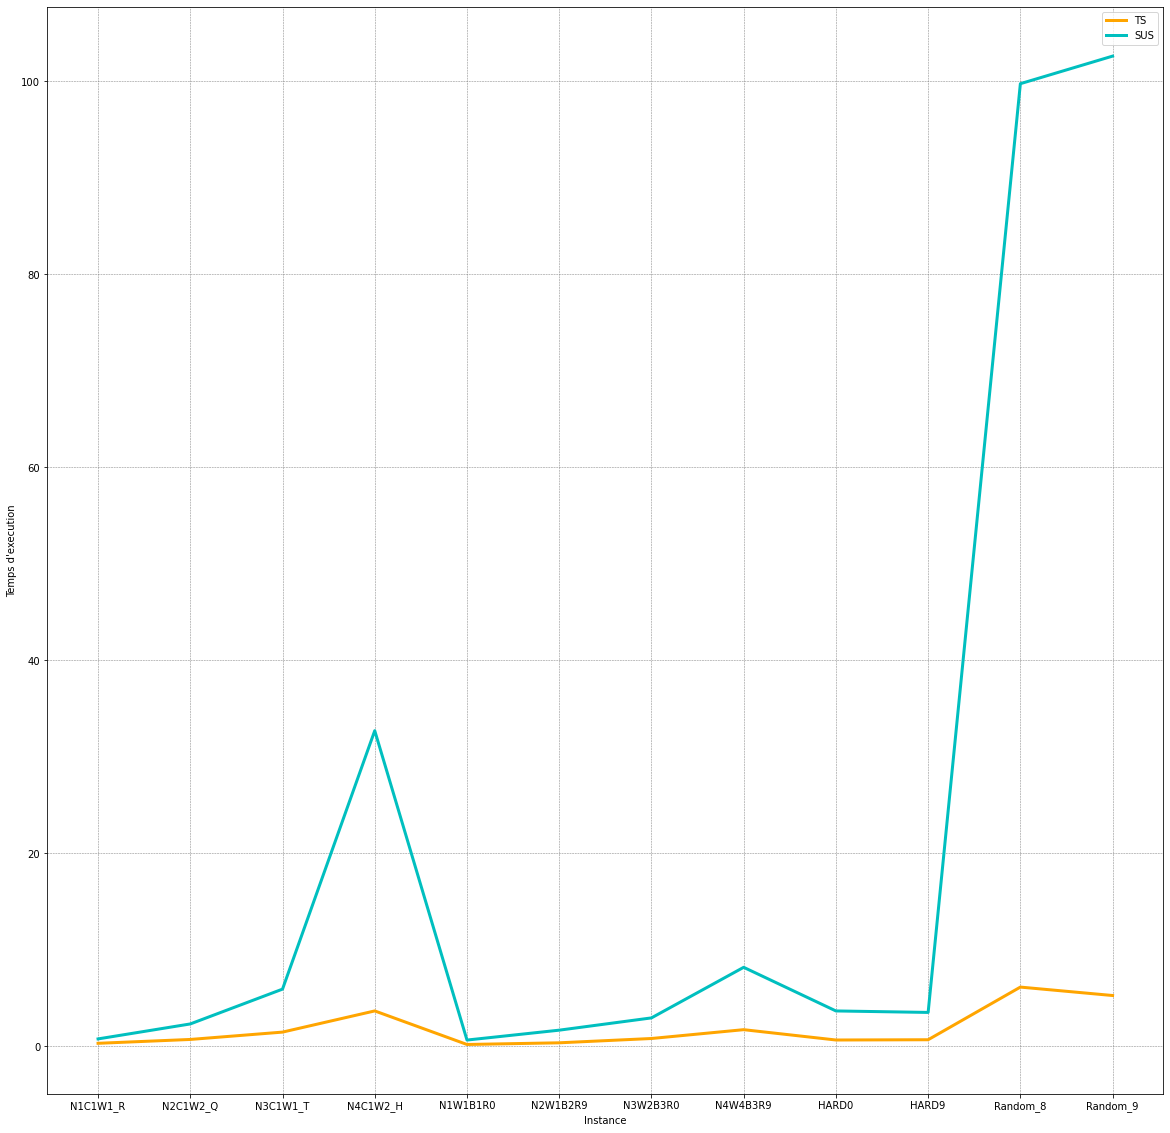

In [63]:
Instances=['N1C1W1_R','N2C1W2_Q','N3C1W1_T','N4C1W2_H','N1W1B1R0','N2W1B2R9','N3W2B3R0','N4W4B3R9','HARD0','HARD9','Random_8','Random_9']
time_RS=[0.3153538703918457, 0.714698076248169, 1.475675106048584, 3.6713428497314453,
         0.19411826133728027, 0.3668968677520752, 0.812894344329834, 1.7282567024230957,
         0.6576812267303467, 0.685246467590332, 6.140858173370361, 5.267725467681885]
time_AG=[00.770475,02.321790,05.928852,32.710010,00.652378,01.676516,02.947876,08.189649,03.669188,03.515036,99.752432,102.610209]
plt.subplots(figsize=(20,20))
br1=np.arange(len(Instances))
plt.plot(Instances, time_RS, color='orange', label='TS',linewidth=3.0)
plt.plot(Instances, time_AG, color='c',label='SUS',linewidth=3.0)
plt.xlabel('Instance')
plt.ylabel("Temps d'execution")
plt.grid(color='gray', linestyle='--',linewidth=0.5)
plt.legend()
plt.show